# Object Detection


This Colab demonstrates use of a TF-Hub module trained to perform object detection.

## Setup


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps


In [2]:
import tensorflow as tf
import tensorflow_hub as hub

In [3]:
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

In [5]:
# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.7.0
The following GPU devices are available: 


### Helper functions for downloading images and for visualization.

Visualization code adapted from [TF object detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py) for the simplest required functionality.

In [6]:
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)

In [40]:
from pathlib import Path
import os
import wget
from urllib.parse import urlparse

In [41]:
def is_remote_url(url_or_filename):
    parsed = urlparse(url_or_filename)
    return parsed.scheme in ("http", "https")

In [62]:
def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
    
    # create and return a unique temporaryfile.
    _, filename = tempfile.mkstemp(suffix=".jpg")
    
    #print(url)
    if is_remote_url(url):
        response = urlopen(url)
        image_data = response.read()
        image_data = BytesIO(image_data)
    else:
        image_data=url
        
        
    pil_image = Image.open(image_data)
    
    # get resized and cropped version of the image, cropped to the requested aspect ratio and size.
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    print("Image downloaded to %s." % filename)
    if display:
        display_image(pil_image)
    return filename



def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
        
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
        
        # Reverse list and print from bottom to top.
        for display_str in display_str_list[::-1]:
            text_width, text_height = font.getsize(display_str)
            margin = np.ceil(0.05 * text_height)
            draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                            (left + text_width, text_bottom)],
                           fill=color)
            draw.text((left + margin, text_bottom - text_height - margin),
                      display_str,
                      fill="black",
                      font=font)
            text_bottom -= text_height - 2 * margin


In [14]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                                25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()
  
    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                           int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
                image_pil,
                ymin,
                xmin,
                ymax,
                xmax,
                color,
                font,
                display_str_list=[display_str])
        np.copyto(image, np.array(image_pil))
    return image

## Apply module

Load a public image from Open Images v4, save locally, and display.

Image downloaded to C:\Users\RPAREPAL\AppData\Local\Temp\tmpp41gjj6_.jpg.


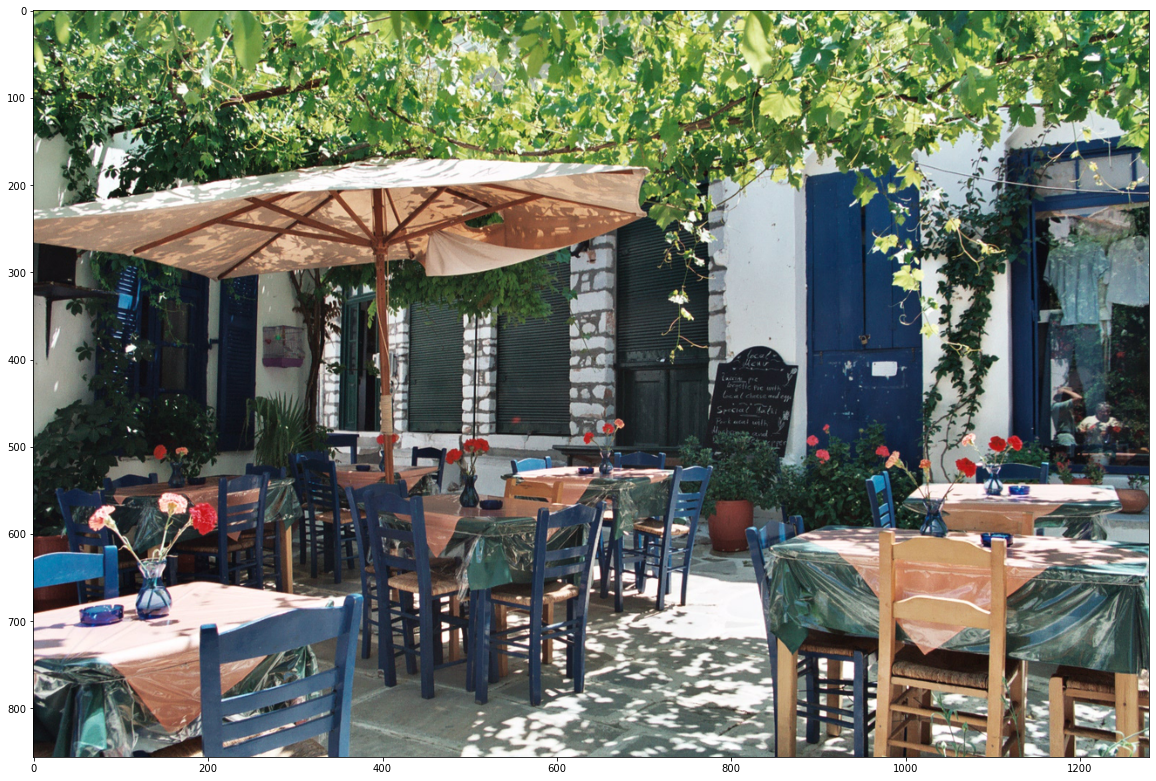

In [82]:
# By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
image_url = "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg"  #@param
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

Pick an object detection module and apply on the downloaded image. Modules:
* **FasterRCNN+InceptionResNet V2**: high accuracy,
* **ssd+mobilenet V2**: small and fast.

In [69]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" 
#@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [72]:
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [79]:
def run_detector(detector, path):
    img = load_img(path)

    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    result = {key:value.numpy() for key,value in result.items()}

    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end_time-start_time)

    image_with_boxes = draw_boxes(
        img.numpy(), result["detection_boxes"],
        result["detection_class_entities"], result["detection_scores"])

    display_image(image_with_boxes)
    #return result

Found 100 objects.
Inference time:  15.753611087799072
Font not found, using default font.


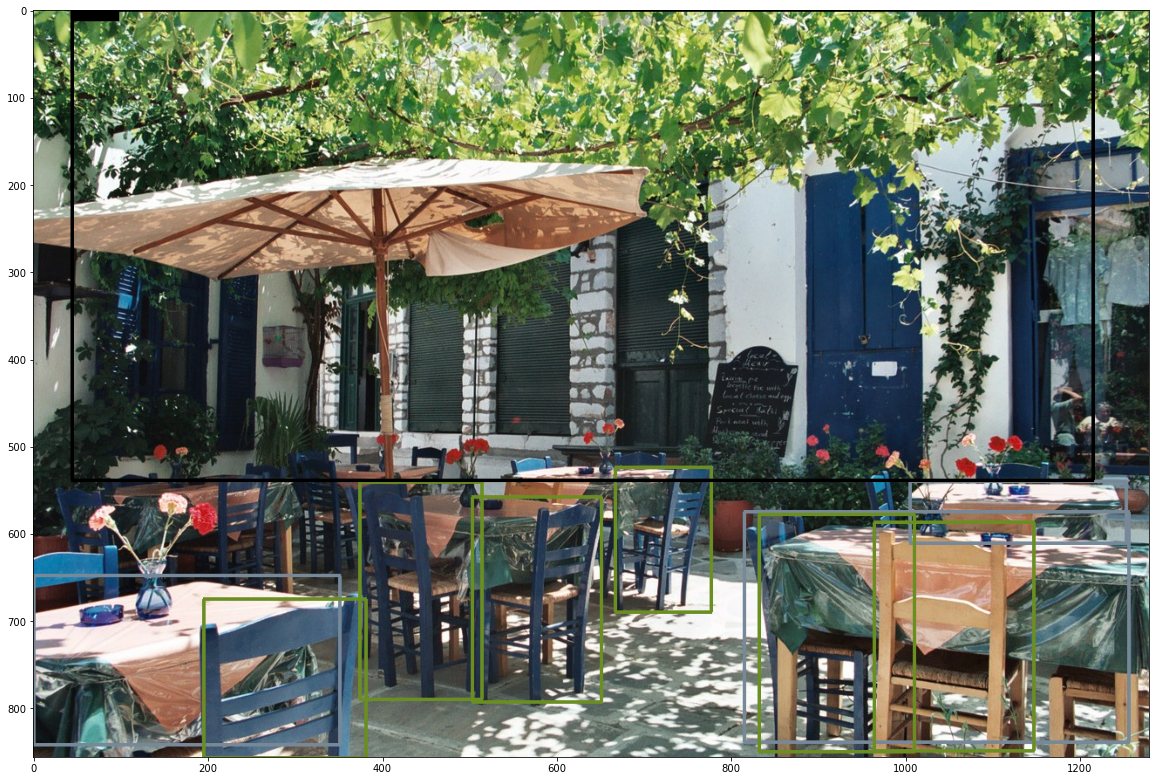

In [83]:
run_detector(detector, downloaded_image_path)
#res=run_detector(detector, downloaded_image_path)

#image_url = "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg"
image_url=os.path.join(Path.cwd(),'Face_Recognition\\Siamese_Model_Implementation_TensorFlow\\data\\faceid\\positive\\5ef2a533-cb82-11ec-889d-8be0aaf8aa85.jpg')
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, False)
run_detector(detector, downloaded_image_path)

### More images
Perform inference on some additional images with time tracking.


In [84]:
image_urls = [
  "https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg",
  "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg",
  "https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg",
  ]

def detect_img(image_url):
    start_time = time.time()
    image_path = download_and_resize_image(image_url, 640, 480)
    run_detector(detector, image_path)
    end_time = time.time()
    print("Inference time:",end_time-start_time)

Image downloaded to C:\Users\RPAREPAL\AppData\Local\Temp\tmp32zqrgxx.jpg.
Found 100 objects.
Inference time:  15.195476055145264
Font not found, using default font.
Inference time: 16.83739948272705


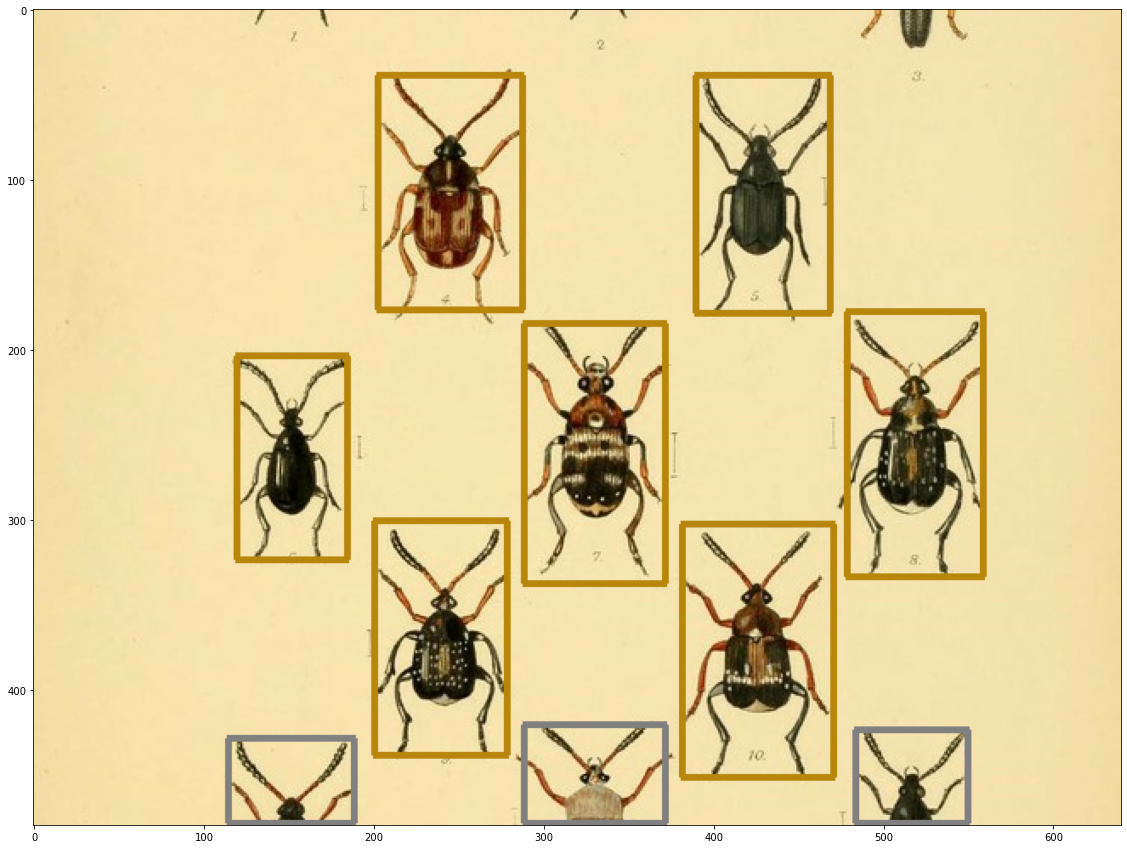

In [85]:
detect_img(image_urls[0])

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  


Image downloaded to /tmpfs/tmp/tmpu7merv3_.jpg.
Found 100 objects.
Inference time:  0.9173905849456787
Font not found, using default font.
Inference time: 1.2230815887451172


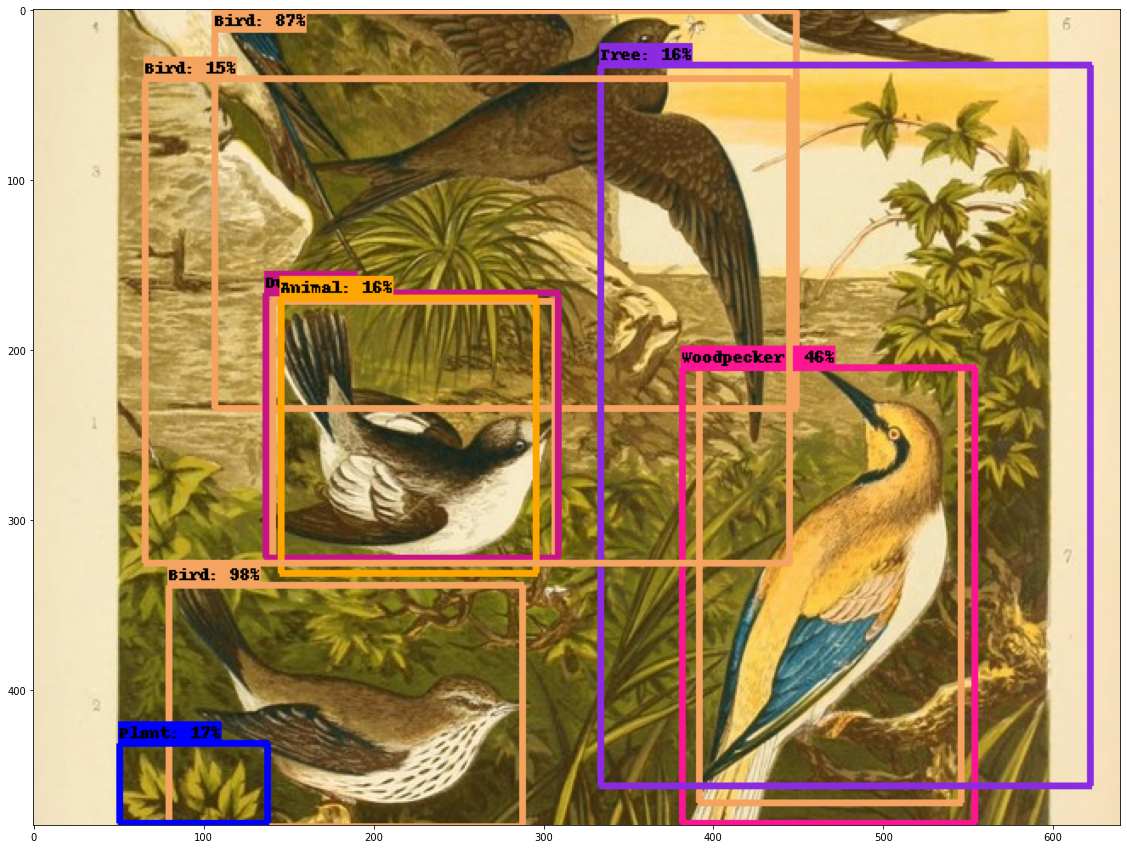

In [12]:
detect_img(image_urls[2])